# CA4 (Group 3)

## Introduction
In the first part of this report, We use **linear regression** (without regularizer) to train the weights. We add a code for **SVM multi-calssification** and verified it with the accuracy of the classification for test dataset. However, we decided to postpone the full implementation for the CA5. 

## Linear regression

### Decentralized Gradient Descent (Algo1 below)
In the preprocessing step we obtained the inputs from the MNIST data set with the following dimensions for training data set. The rows of $X$ are 28x28 matrix (image) values with rows concatenated to form row of size 784. 

1. $X$ is ndarray with dimension 60000x784
2. $Y$ is ndarray with dimension 60000x1
3. $\mathbf{w}$ is ndarray with dimension 784x1

The gradient is computed as follows:
\begin{equation}
\text{gradient} = -2X^T(Y-X\mathbf{w}).
\end{equation}

We have used backtracking line search for finding the step size ($2.38$x$10^{-7}$). By uing this step size, we found the norm of the gradient reduces monotonically. However, the convergence of GD is very slow, taking hours for the norm of the gradient to reduce to zero (theoretical stopping conditoin). Therefore, we terminate the training (Algo1 below) after a specified number of iterations. 



In [2]:
import pandas as pd
import numpy as np
import math
import time
import keras

Using TensorFlow backend.


In [9]:
### Read the training data ### 
df = pd.read_csv('mnist_train.csv',index_col=False,header=None)

N = 60000 #Total numer of data samples
m = 10 #Number of workers
num_classes = 10 #Number of output classes
image_size = 784

y_train = df.values[:,0].astype('float32')
y_train = y_train.reshape([N,1])
y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = df.values[:,1:(image_size + 1)].astype('float32')

## Save the formatted arrays
np.savetxt("y_train.csv", y_train, delimiter=",",fmt='%.1f')
np.savetxt("x_train.csv", x_train, delimiter=",",fmt='%.1f')

### Read the test data ###
df_test = pd.read_csv('mnist_test.csv',index_col=False,header=None)

M = 10000 #Number of test samples
y_test = df_test.values[:,0].astype('float32')
y_test = y_test.reshape([M,1])
y_test = keras.utils.to_categorical(y_test, num_classes)
x_test = df_test.values[:,1:(image_size+1)].astype('float32')

## Save the formatted arrays
np.savetxt("y_test.csv", y_test, delimiter=",",fmt='%.1f')
np.savetxt("x_test.csv", x_test, delimiter=",",fmt='%.1f')



In [10]:
#Load the training and testing data sets
x_train = pd.read_csv("x_train.csv", delimiter=",", header=None).values
y_train = pd.read_csv("y_train.csv", delimiter=",", header=None).values

x_test = pd.read_csv("x_test.csv", delimiter=",", header=None).values
y_test = pd.read_csv("y_test.csv", delimiter=",", header=None).values


#Divide the training data set into 10 data sets
N = 60000
M = 10000
m = 10 #Number of workers
num_classes = 10 #Number of output classes
image_size = 784
numSamples = N//m #Number of training samples per worker

X = {}
Y = {}
Z = {}
for idx in range(m):
    Y[idx] = y_train[idx*numSamples:(idx+1)*numSamples,:]
    X[idx] = x_train[idx*numSamples:(idx+1)*numSamples,:]

In [30]:
#Intialize the parameters
epsilon = 0.01
Iterations = 1000
w = np.zeros([image_size,num_classes])
p = 0.9
sigma = 1e6
learn_rate = 2.38e-7 #This learning rate was inferred by using backtracking_line_search

#This function is used to find an appropriate learning rate (step size)
def backtracking_line_search(grad,w):
    alpha = 0.2
    beta = 0.5
    t = 1
    while 1:
        z = w - t*grad
        a = y_train - np.matmul(x_train,z)
        b = y_train - np.matmul(x_train,w)
        if (np.sum(a ** 2) >= np.sum(b ** 2) - alpha*t*(np.sum(grad ** 2))):
            t = t*beta
        else:
            break
    print('t',t)
    return t

#The dimensions are expressed with respect to train data
#X is ndarray with dimension 6000x784
#Y is ndarray with dimension 6000x10
#w is ndarray with dimension 784x10
def compute_gradient(X,Y,w):
    return -2*np.matmul(X.T, Y - np.matmul(X,w))

#Linear Regression Loss
def reg_loss(w):
    a = y_test - np.matmul(x_test,w)
    return 1./M*(np.sum(a ** 2))

#Compute the classification error. Using the trained weight vector, we compute, for each vector y_j [\sum_{i=1}^{M} x_i w_{ij}] , which is the estimated vector for y
#w = pd.read_csv("w50_noError.csv", delimiter=",", header=None).values
def compute_classification_err(w):
    y_estimate = np.matmul(x_test,w)
    num_err = 0
    M = 10000
    for i in range(M):
        if np.argmax(y_test[i,:]) != np.argmax(y_estimate[i,:]):
            num_err = num_err + 1

    return num_err*100.0/M

#Distributed Gradient Descent
def DGD(w,learn_rate,epsilon,p,sigma,Iterations):
    itr = 0
    maxIterations = 1000
    lin_reg_loss = np.zeros([Iterations,1])
    classification_err = np.zeros([Iterations,1])
    while 1:
        grad = np.zeros([image_size,num_classes])
        for idx in range(m):
            #gradient of f: -2*X.T*(Y-X*w)
            gf = compute_gradient(X[idx],Y[idx],w)

            #Adding noise based on p and sigma (R = sigm^2)
            if np.random.random() < p:
                gf = gf + np.random.normal(0, sigma,[784,10])
            
            grad = grad + gf
                    
        grad = grad/N
        #learn_rate = backtracking_line_search(grad,w)
        w = w - learn_rate*grad
        
        grad_norm = math.sqrt(np.sum(grad ** 2))
        print('grad norm:',grad_norm)

        if grad_norm < epsilon or itr >= Iterations:
            print('grad abs max:',abs(grad).max())
            break
        
        lin_reg_loss[itr] = reg_loss(w)
        classification_err[itr] = compute_classification_err(w)
        
        print(itr)
        itr = itr + 1
        
    return w, classification_err, lin_reg_loss;

start = time.time() 
w, classification_err, lin_reg_loss = DGD(w,learn_rate,epsilon,p,sigma,Iterations)  
end = time.time()
print('time=',end-start,' seconds')
np.savetxt('w1000_p5_sigma1e6.csv',w,delimiter=',')
np.savetxt('classification_err_1000_p9_sigma1e6.csv',classification_err,delimiter=',')
np.savetxt('lin_reg_loss_1000_p9_sigma1e6.csv',lin_reg_loss,delimiter=',')

grad norm: 4244.81180052428
0
grad norm: 3930.4110040095866
1
grad norm: 4452.403977518767
2
grad norm: 4509.159863021487
3
grad norm: 4678.887243368459
4
grad norm: 4183.181071766754
5
grad norm: 4460.392309455723
6
grad norm: 4393.367179348113
7
grad norm: 3921.9622662422894
8
grad norm: 4342.991341328872
9
grad norm: 4158.188766417255
10
grad norm: 4707.556068224707
11
grad norm: 3903.57721461894
12
grad norm: 4203.424443974358
13
grad norm: 4793.641611696008
14
grad norm: 4443.343930248317
15
grad norm: 4426.281897517981
16
grad norm: 4422.91553333528
17
grad norm: 4449.604640012665
18
grad norm: 4489.553296180574
19
grad norm: 4456.330329830257
20
grad norm: 4441.028361688807
21
grad norm: 3938.7759032525323
22
grad norm: 4470.564674448143
23
grad norm: 4370.938862713677
24
grad norm: 4174.42113682317
25
grad norm: 4168.563497953426
26
grad norm: 4165.41502405011
27
grad norm: 4688.08170346374
28
grad norm: 4713.444548293469
29
grad norm: 4748.054907644
30
grad norm: 4262.10152245

252
grad norm: 4429.9859817263405
253
grad norm: 4167.20246301091
254
grad norm: 4685.589203651131
255
grad norm: 3884.1460251198587
256
grad norm: 4226.617549780395
257
grad norm: 4372.59358685327
258
grad norm: 4677.656311254498
259
grad norm: 4680.205091681098
260
grad norm: 4432.368068125477
261
grad norm: 4448.066327622121
262
grad norm: 4716.040332140309
263
grad norm: 4442.496635659394
264
grad norm: 4467.946338248088
265
grad norm: 4204.482753877233
266
grad norm: 3973.242109717722
267
grad norm: 4652.78950308637
268
grad norm: 4665.076697431856
269
grad norm: 4465.94716910617
270
grad norm: 4738.569096635207
271
grad norm: 4226.488503823547
272
grad norm: 4409.439010606002
273
grad norm: 4445.393562700166
274
grad norm: 4450.334063427947
275
grad norm: 4693.193769219064
276
grad norm: 4172.713829704469
277
grad norm: 4187.273813110292
278
grad norm: 4388.715738619282
279
grad norm: 4379.981574549912
280
grad norm: 4404.8287034899695
281
grad norm: 4704.718909862933
282
grad no

grad norm: 4177.812786439693
501
grad norm: 3944.5673734377433
502
grad norm: 4410.699899429906
503
grad norm: 4196.119801024683
504
grad norm: 4208.116590623596
505
grad norm: 4446.383671038925
506
grad norm: 4685.325606621018
507
grad norm: 4721.307634199927
508
grad norm: 4719.715890982229
509
grad norm: 4425.241022064683
510
grad norm: 4178.935894406003
511
grad norm: 3631.8814949818748
512
grad norm: 4167.716456292854
513
grad norm: 4695.133258014159
514
grad norm: 4455.178606399625
515
grad norm: 4695.5916228127835
516
grad norm: 4745.996140438892
517
grad norm: 3933.6857786345563
518
grad norm: 4697.132116174917
519
grad norm: 4692.571209542815
520
grad norm: 4169.551439835915
521
grad norm: 4665.077125257539
522
grad norm: 4683.288303851811
523
grad norm: 4624.94530892193
524
grad norm: 4458.660325423883
525
grad norm: 4681.706607435142
526
grad norm: 4187.434988589401
527
grad norm: 4458.355667583941
528
grad norm: 4164.985472413482
529
grad norm: 3342.853802538881
530
grad no

749
grad norm: 4671.054146534181
750
grad norm: 4167.684442901184
751
grad norm: 4610.930046084307
752
grad norm: 4472.298919009738
753
grad norm: 4386.3219489167905
754
grad norm: 4400.910561526744
755
grad norm: 4208.550686410903
756
grad norm: 4432.099731778289
757
grad norm: 4666.612409105621
758
grad norm: 4436.320131823491
759
grad norm: 4608.294212049101
760
grad norm: 4445.349246591833
761
grad norm: 4177.495198215362
762
grad norm: 4640.683310939469
763
grad norm: 4640.277267561462
764
grad norm: 4429.08524342313
765
grad norm: 3920.615234709134
766
grad norm: 4413.26385148082
767
grad norm: 4643.072657453442
768
grad norm: 4674.058973576305
769
grad norm: 4700.362645030992
770
grad norm: 4368.080689905171
771
grad norm: 4733.8016578385495
772
grad norm: 3925.2609393100925
773
grad norm: 4742.446161726775
774
grad norm: 4468.801929044019
775
grad norm: 4636.868173200549
776
grad norm: 4661.838086018453
777
grad norm: 4089.0460706944764
778
grad norm: 4160.915160336422
779
grad

998
grad norm: 3884.4226761144287
999
grad norm: 4167.620290308101
grad abs max: 191.70862611970793
time= 207.10140800476074  seconds


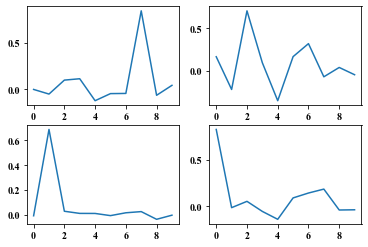

In [66]:
import matplotlib.pyplot as plt


for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.plot((np.matmul(x_test,w))[i,:])

### Example visualization of the classification obtained using the trained weights (no Noise case) The first four digits of the test data are 7,2,1,0. Note the peak values in the figures below occur at these numbers.


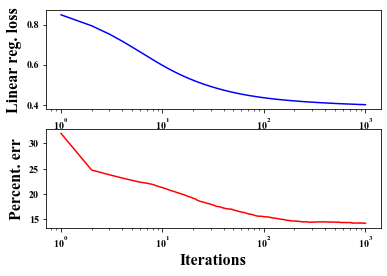

In [67]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 10})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


ax = plt.subplot(2, 1, 1)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Linear reg. loss", fontsize=16)
plt.semilogx(list(range(1,Iterations+1)),lin_reg_loss,'-b')

ax = plt.subplot(2,1,2)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Percent. err", fontsize=16)
plt.semilogx(list(range(1,Iterations+1)),classification_err,'-r')
   

### Linear regression loss and cloassification error for no noise case.

## Part A: Affect of $p$ and $R$ on Convergence
In order to illustrate the affect of $p$ and $R$ on the convergence rate, we first train the weights with no noise for 50 iterations. We compute norm of the gradient using this $\mathbf{w}$ and then find the number of iterations it takes to achieve the same norm value in the presence of noise. For different $R$ values, we vary $p$ and obtain the number of iterations as the minimum over multiple runs. Note number of iterations differ between runs for the same $p$ and $R$ values because of the random values generated in each run differ. 

Our choice of $R$ is infludence by the learning rate we use: $2.38$x$10^{-7}$ and the number of samples over which the gradient is averaged. If the standard deviation of the normal random variable used for adding the noise is smaller than $10^{6}$, no significant affect can be observed as it will be nullified when multiplying with learning rate and divided by the number of samples. Therefore, we choose the standard deviation of the order of $10^9$ and thus $R$ is of the order of $10^{18}$.

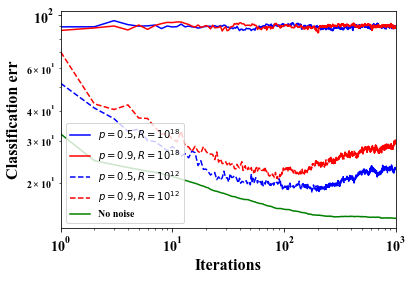

In [35]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 10})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification err", fontsize=16)

classification_err = pd.read_csv("classification_err_1000_p5_sigma1e9.csv", delimiter=",", header=None).values
plt.loglog(list(range(1,Iterations+1)),classification_err,'-b',label = '$p = 0.5, R = 10^{18}$')

classification_err = pd.read_csv("classification_err_1000_p9_sigma1e9.csv", delimiter=",", header=None).values
plt.loglog(list(range(1,Iterations+1)),classification_err,'-r',label = '$p = 0.9, R = 10^{18}$')

classification_err = pd.read_csv("classification_err_1000_p5_sigma1e6.csv", delimiter=",", header=None).values
plt.loglog(list(range(1,Iterations+1)),classification_err,'--b',label = '$p = 0.5, R = 10^{12}$')

classification_err = pd.read_csv("classification_err_1000_p9_sigma1e6.csv", delimiter=",", header=None).values
plt.loglog(list(range(1,Iterations+1)),classification_err,'--r',label = '$p = 0.9, R = 10^{12}$')

#classification_err = pd.read_csv("classification_err_1000_p5_sigma1e4.csv", delimiter=",", header=None).values
#plt.loglog(list(range(1,Iterations+1)),classification_err,'--b',label = '$p = 0.5, R = 10^{8}$')

#classification_err = pd.read_csv("classification_err_1000_p9_sigma1e4.csv", delimiter=",", header=None).values
#plt.loglog(list(range(1,Iterations+1)),classification_err,'--r',label = '$p = 0.9, R = 10^{8}$')

classification_err = pd.read_csv("classification_err_1000_noNoise.csv", delimiter=",", header=None).values
plt.loglog(list(range(1,Iterations+1)),classification_err,'-g',label = 'No noise')

legend()

From the above figure, we infer that, as $p$ and $R$ increases, the number of iterations required to achieve the same gradient norm in the noiseless case (with in 50 iterations), increases quickly.

## Part B - Decentralized subgradient method over Multihop Networks.

The two-star topology of network studied is shown in the picture below.

![](twostar.pdf)

### Transition Matrix Definition

The connectivity of the network can be described with the following (double stochastic) transition matrix.  

  
$$A = 
\begin{pmatrix}
5/6 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 5/6 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 5/6 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 5/6 & 1/6 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 0 & 1/6 & 5/6 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 5/6 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 5/6 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 5/6
\end{pmatrix}$$

In [ ]:
A = np.identity(10)*(5/6)
A[4,0:6]  = 1/6
A[5,5:10] = 1/6
A[0:6,4]  = 1/6
A[5:10,5] = 1/6
#print(A)

At each iteration, every agent $i$ must share their weights $w_i$ to reach a consensus among neighbors. In this step, with probability p, each node adds noise with variance R to their weight before sharing. The consensus is then calculated over the noisy weights. After this, the second step is for each agent to compute their subgradient using the consensus weights, and then update their weights to be used in the following iteration.

### Step 1: Consensus 

$\bar{w}_{i,k} = \sum_{i \in N_i}^{} a_{i,j}w_{j,k}$

### Step 2: Subgradient descent

$w_{i,k+1} = \bar{w}_{i,k}-\alpha_kg_i(\bar{w}_{i,k})$

In [ ]:
def addNoiseB(w,p,R):
    Q, N = w.shape
    w_noise = np.zeros((Q,N))
    for i in range(N):
        if np.random.random() < p:
            w_noise[:,i] = w[:,i] + np.random.normal(0, math.sqrt(R))
        else:
            w_noise[:,i] = w[:,i]
    return w_noise

def DSGD(X,Y,alpha,w,A,p,R,num_iter):
    Q,N     =  w.shape
    w_prev  =  w
    w_noise =  np.zeros((Q, N))
    w_      =  np.zeros((Q, N))
    grad    =  np.zeros((Q, N))
    
    for i_iter in range(num_iter):
        
        #Step 1: consensus
        w_noise = addNoiseB(w_prev,p,R)
        w_ = w_noise.dot(A)

        #Step 2: each agent computes its subgradient descend
        for n in range(N):
            aux = w_[:,n]
            var = compute_gradient(X[n],Y[n],aux.reshape((784,1)))
            if n == 1:
                print(np.linalg.norm(var))
            grad[:,n] = var.reshape((784,))
        w_prev = w_ - alpha*grad
    
    return w_prev   

## Part C - Critical Nodes

In the network studied in Part A, the most important node to protect is the master node since it is a single point of failure. The other two nodes could be selected randomly among the workers or considering different criteria such as the weights of each node.

Similarly, in the case of the two-star topology of Part B, nodes 5 and 6 are the most critical nodes to protect since they connect the two stars. The third node can be selected randomly, based on which star it belongs to, based on weights, or any other criteria.

## SVM multi-classification


In [1]:
# Import libraries
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from random import randint
import numpy as np

Using TensorFlow backend.


In [ ]:
# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

### SVM classifier (Hinge function)
In this project we use the notion of SVM multi-classification.
$X$ is the data $60000\times 784$ and $Y$ is $60000\times 10$. The weights to be learned are $W$ which is $784\times 10$.


Let $y=[1,0,...,0]^T$ represnting class 1 and $y=[0,1,0,..,0]^T$ representing class 2.
The loss for each sample is defined as:
$$L_i = \sum_{j\neq y_i} \left[ \max(0, w_j^Tx_i - w_{y_i}^Tx_i + \Delta) \right].$$

Now the gradient can be derived as:
$$\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) \right) x_i$$

and 

$$\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0) x_i$$


In [20]:
# Define cost functions

# Condition metric
def H(X, y, theta):
    out=np.asarray([ np.sum(np.maximum(0,1+(X[i]@theta) - (y[i])*(X[i]@theta))) for i in range(X.shape[0])])
    return out


# SVM loss function
def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*np.linalg.norm(theta,ord='fro')
    loss = np.mean(h)
    #print('loss=',loss)
    #print('penalty=',penalty)
    return penalty + loss 

# Gradient of SVM loss function
def svm_grad_re(X, y, theta, lamda): 
    grad=np.zeros((X.shape[1],num_classes))
    for i in range(X.shape[0]):
        s=np.where((X[i]@theta) - (y[i])*(X[i]@theta)>0,1,0)- y[i]*np.sum(np.where((X[i]@theta) - (y[i])*(X[i]@theta)>0,1,0))
        grad+=np.tensordot(s,X[i],axes=0).T
    grad=grad/X.shape[0]
    
    grad=grad+2*lamda*theta
    return grad

def test_accuracy(X,y,theta):  
    out=np.mean([keras.utils.to_categorical(np.argmax(X[i]@theta),num_classes).dot(y[i]) for i in range(X.shape[0])])
    return out


In [21]:
#Split dataset to num_worker workers
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

# Function to train master-worker
def train(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    
    # lamda: penalty
    # alpha: learning rate
    # var: noise variance
    # pLevel: noise adding probability
    # num_iter: number of iterations
    
    # Split into 10 subdatasets for 10 workers
    data_X_list, data_y_list = split_workers(X_data, y, num_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 10)
    
    total_loss_list=[]
    accu=[]
    for i_iter in range(num_iter):
        gradient_list=[]
        # Fill in
        for j_worker in range(num_worker):
            # call data_j from worker j
            data_X_j=data_X_list[j_worker]
            data_y_j=data_y_list[j_worker]
            # get grad from worker j
            gradient_list.append(svm_grad_re(data_X_j, data_y_j, weight, lamda))
            # add noise
            
        # Fill in        
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        loss=svm_loss_re(X_data, y, weight, lamda)
        print(loss)
        total_loss_list.append(loss)
        #print(total_loss_list[-1])
        
        
        #Compute test accuracy
        ac=test_accuracy(x_test,y_test,weight)
        print('Acc=',ac)
        print('***')
        accu.append(ac)
    return total_loss_list,accu



In [22]:
loss, accuracy=train(x_train, y_train, num_worker=1, num_iter=50, var=0, pLevel=0, lamda=0.2, alpha=0.01, lr_fade=0.99)

112359.9324495582
Acc= 0.6628
***
107438.00482249378
Acc= 0.6733
***
103334.11037665376
Acc= 0.6869
***
102172.30367228738
Acc= 0.6873
***
101952.16800565907
Acc= 0.7005
***
102308.03088642968
Acc= 0.7063
***
102813.5409137593
Acc= 0.7152
***
103312.71983088896
Acc= 0.7235
***
103802.80252354662
Acc= 0.731
***
104305.73244610267
Acc= 0.7363
***
104875.01501169353
Acc= 0.7387
***
105550.54784025076
Acc= 0.7422
***
106316.1861857616
Acc= 0.7432
***
107145.10194579317
Acc= 0.7461
***
108020.81255586256
Acc= 0.7478
***
108921.86271848518
Acc= 0.7485
***
109835.6020265664
Acc= 0.7503
***
110748.31348514163
Acc= 0.7515
***
111659.71324758993
Acc= 0.7528
***
112562.96364044544
Acc= 0.7535
***
113449.30232184555
Acc= 0.7544
***
114321.68132495115
Acc= 0.7554
***
115183.86694241708
Acc= 0.7564
***
116034.0461097722
Acc= 0.7568
***
116868.69138185825
Acc= 0.7574
***
117690.34353934582
Acc= 0.7582
***
118497.22803429989
Acc= 0.7589
***
119289.295286999
Acc= 0.7591
***
120065.14139077475
Acc= 0.75

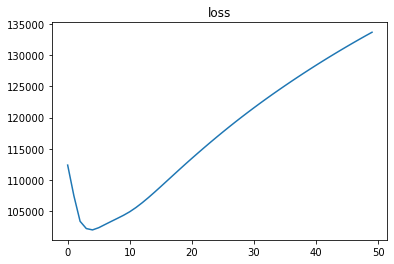

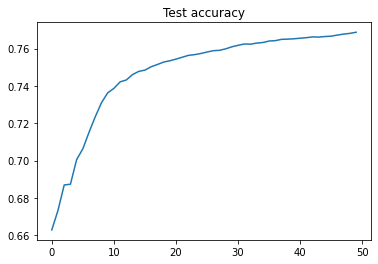

In [23]:
plt.plot(np.arange(50),loss)
plt.title('loss')
plt.show()

plt.plot(np.arange(50),accuracy)
plt.title('Test accuracy')
plt.show()